In [3]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

from snaptools import simulation
from snaptools import snapshot
from snaptools import combine_gals
from snaptools import manipulate as man
from snaptools import utils
from snaptools import plot_tools
from scipy import stats

import astropy.units as u
from astropy import constants
import sys
import  moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import conversions as co
from snaptools import convert
import datetime
from PIL import Image
from astropy.io import fits
import glob

import h5py
import pNbody as pnb

%matplotlib inline

In [5]:
folder = '../Data/output_stream_fixed/'
snapshots = glob.glob(folder+'snapshot.csv.*')

lmc = np.empty((len(snapshots), 10))
smc = np.empty((len(snapshots), 10))

for i, snap in enumerate(snapshots):
    names = np.loadtxt(snap, skiprows=1, delimiter=",", usecols=(0,), dtype='S4')
    d = np.loadtxt(snap, skiprows=1, delimiter=",",  usecols=(range(1,11)))
    smc[i, :] = d[names == 'SMC', :]
    lmc[i, :] = d[names == 'LMC', :]

In [6]:
r1 = np.sqrt(np.sum(lmc[:, :3]**2, axis=1))*u.kpc
v1 = np.sqrt(np.sum(lmc[:, 3:6]**2, axis=1))*(u.km/u.s)

In [11]:
#MW values from Kupper et al. 2015
c = 5.14
M200 = 1.56E+12*u.solMass
r200 = 194.8*u.kpc
rs = r200/c
print rs

const = 2273.89

rhov=const*u.solMass/u.kpc**3

37.8988326848 kpc


In [12]:
def ram_pressure(rho, rel_vel):
    return 0.5*rho*rel_vel**2


def hot_halo(r, rhov, c, rs):
    x = r/rs
    return rhov*(1 + 3.7/x*np.log(1. + x) - 3.7/c*np.log(1. + c))**1.5



In [89]:
hot_halo(200*u.kpc, rhov, c, rs).to(u.g/(u.cm**3))

<Quantity 1.4970254788475196e-28 g / cm3>

In [179]:
rho = hot_halo(r1, rhov, c, rs).to(u.g/u.cm**3)
rp = ram_pressure(rho, v1)

In [47]:
time = -1*lmc[:, 9]

deltaT = 2.
begin_time = time[np.min(np.where(r1.value > 75)[0])]
print begin_time
use = np.where((time > begin_time)*(time < begin_time+deltaT))

0.2501


In [130]:
with open('chad_hot_halo.txt', 'w') as f:
    f.write('T,R,V,Rho\n')
    for iuse in use[0]:
        f.write("{:1.5f},{:1.5f},{:1.5f},{:1.5f}\n".format(time[iuse], r1[iuse].value,
                                                           v1[iuse].value, rho[iuse].value))

In [175]:
def poly_string(poly_params):
    
    order = len(poly_params)
    string = ''
    for i, p in enumerate(poly_params):
        i += 1
        operator = ' + ' if p > 0 else ' - '
        power = '$^{:d}$'.format(order-i) if (order-i > 1) else ''
        symbol = 't' if (order-i > 0) else ''
        string += '{:s}{:2.2f}{:s}{:s}'.format(operator, np.abs(p), symbol, power)
        
    return string[3:]



In [182]:
density_conversion = (1.*u.g/(u.cm**3)).to(u.solMass/(u.kpc**3))

In [186]:
vel_params = np.polyfit(time[use], v1[use].value, 2)
vel_poly = np.poly1d(vel_params)

r_params = np.polyfit(time[use], r1[use].value, 2)
r_poly = np.poly1d(r_params)

rho_params = np.polyfit(time[use], rho[use].value, 3)
rho_poly = np.poly1d(rho_params)

rho_params = np.polyfit(time[use], rho[use].value*1e+28, 3)
rho_poly = np.poly1d(rho_params)

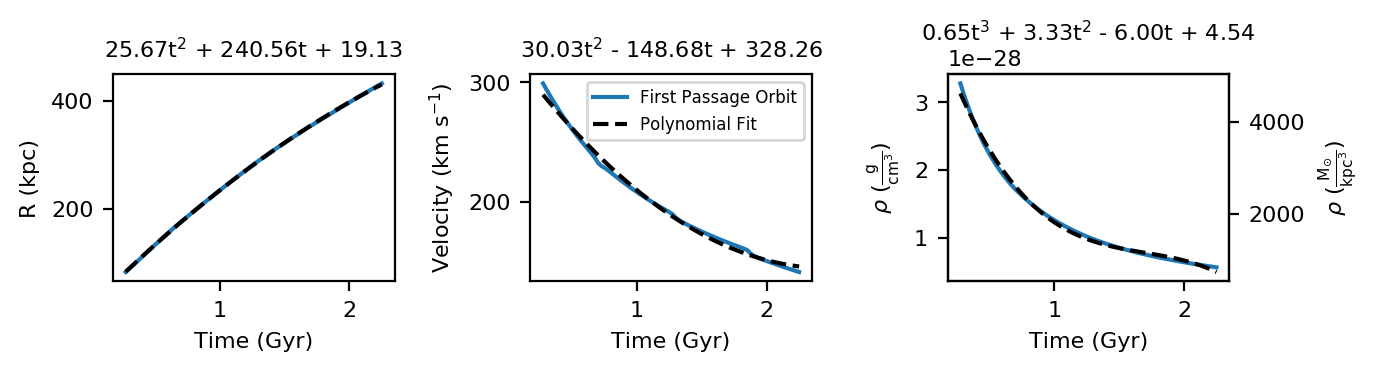

In [187]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2), dpi=200)

fontsize=8

axis = axes[0]

axis.plot(time[use], r1[use])
axis.plot(time[use], r_poly(time[use]), color='black', linestyle='--')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel('R (kpc)')

axis.set_title(poly_string(r_params))

axis = axes[1]

axis.plot(time[use], v1[use], label='First Passage Orbit')
axis.plot(time[use], vel_poly(time[use]), color='black', linestyle='--', label='Polynomial Fit')

axis.legend(fontsize=fontsize-2)

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'Velocity (km s$^{-1}$)')

axis.set_title(poly_string(vel_params))

axis = axes[2]

axis.plot(time[use], rho[use])
axis.plot(time[use], rho_poly(time[use])*1e-28, color='black', linestyle='--')

#axis.set_yscale('log')

axis.set_xlabel('Time (Gyr)')
axis.set_ylabel(r'$\rho$ ({:s})'.format(rho[0].unit.to_string('latex')))

axis.set_title(poly_string(rho_params), y=1.08)

ax2 = axis.twinx()
mn, mx = axis.get_ylim()
ax2.set_ylim(mn*density_conversion.value, mx*density_conversion.value)
ax2.set_ylabel(r'$\rho$ ({:s})'.format(density_conversion.unit.to_string('latex')))

for ax in np.append(axes, ax2):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.offsetText] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
fig.tight_layout()
